# Experiments in Calibrating Zero-Shot Image Classifiers

This notebooks contains code for experimenting with different calibration methods for binary classifiers, applied to the use case of zero-shot image classification.

## Install Dependencies

In [1]:
! pip install open_clip_torch
! pip install --upgrade datasets
! pip install relplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Import Libraries

In [2]:
import pathlib

import datasets
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import pandas as pd
import PIL.Image
import PIL.PngImagePlugin
import relplot
import scipy.special
import sklearn.calibration
import sklearn.isotonic
import sklearn.metrics
import sklearn.model_selection
import torch

# fix image loading errors for some large files in ImageNet-1k
PIL.PngImagePlugin.MAX_TEXT_CHUNK = 100 * (1024**2)

## Fetch Datasets

In [3]:
DATASET_URLS = {
    # Aerial Image Dataset: https://captain-whu.github.io/AID/
    "aid": "https://drive.google.com/uc?id=1w_eK6VJbUEBrWzvM8pWfJ1xMcZZzBb1z",
    # MIT Places 365: http://places2.csail.mit.edu/
    "places365": "https://drive.google.com/uc?id=1z8tUqCbP25ZKciJGAYa3QuTYJ7_SmzfQ",
}

In [4]:
for dataset_name, dataset_gdrive_url in DATASET_URLS.items():
    ! gdown {dataset_gdrive_url}
    ! unzip /content/{dataset_name}.zip

Downloading...
From (original): https://drive.google.com/uc?id=1w_eK6VJbUEBrWzvM8pWfJ1xMcZZzBb1z
From (redirected): https://drive.google.com/uc?id=1w_eK6VJbUEBrWzvM8pWfJ1xMcZZzBb1z&confirm=t&uuid=0f409ee0-4974-466b-963f-86554be632f4
To: /content/aid.zip
100% 81.7M/81.7M [00:00<00:00, 100MB/s]
Archive:  /content/aid.zip
   creating: aid/
  inflating: aid/state.json          
  inflating: aid/dataset_info.json   
  inflating: aid/data-00000-of-00001.arrow  
Downloading...
From (original): https://drive.google.com/uc?id=1z8tUqCbP25ZKciJGAYa3QuTYJ7_SmzfQ
From (redirected): https://drive.google.com/uc?id=1z8tUqCbP25ZKciJGAYa3QuTYJ7_SmzfQ&confirm=t&uuid=9a9b3af3-76f9-4723-b3c9-4b3aa4da4f04
To: /content/places365.zip
100% 1.21G/1.21G [00:08<00:00, 146MB/s]
Archive:  /content/places365.zip
   creating: places365/
  inflating: places365/state.json    
  inflating: places365/dataset_info.json  
  inflating: places365/data-00002-of-00003.arrow  
  inflating: places365/data-00000-of-00003.arrow  


## Implement Zero-Shot Classifier and Calibrators

In [19]:
class ZeroShotClassifier:
    """Wrapper for loading and running zero-shot image classifiers."""

    TEMPLATES = [
        "itap of a {}.",
        "a bad photo of the {}.",
        "a origami {}.",
        "a photo of the large {}.",
        "a {} in a video game.",
        "art of the {}.",
        "a photo of the small {}.",
    ]

    def __init__(self, model_name, pretrained_source, device):
        self.model_name = model_name
        self.pretrained_source = pretrained_source
        self.device = device
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            self.model_name,
            pretrained=self.pretrained_source,
        )
        self.model.eval().to(device)
        self.tokenizer = open_clip.get_tokenizer(self.model_name)
        self.text = None
        self.text_features = None

    def set_text(self, text):
        self.text = text
        tokens = self.tokenizer([t.format(self.text) for t in ZeroShotClassifier.TEMPLATES])
        with torch.no_grad(), torch.amp.autocast("cuda"):
            text_features = self.model.encode_text(tokens.to(self.device))
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.mean(dim=0)
            text_features /= text_features.norm()
        self.text_features = text_features.to("cpu").numpy()

    def get_image_features(self, image: PIL.Image.Image):
        input_features = self.preprocess(image).unsqueeze(0)
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.to("cpu").numpy()

    def get_image_features_batch(self, images):
        input_features = torch.stack([self.preprocess(im) for im in images])
        with torch.no_grad(), torch.amp.autocast("cuda"):
            image_features = self.model.encode_image(input_features.to(self.device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features.cpu().numpy()

    def score_image(self, image: PIL.Image.Image, with_features: bool = False):
        image_features = self.get_image_features(image)
        score = (image_features @ self.text_features).item()
        results = {"score": score.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

    def score_image_batch(self, images, with_features=False):
        image_features = self.get_image_features_batch(images)
        scores = image_features @ self.text_features
        results = {"score": scores.astype(np.float32)}
        if with_features:
            results["features"] = image_features
        return results

    def score_features(self, image_features: np.ndarray):
        score = (image_features @ self.text_features).item()
        return score.astype(np.float32)

    def score_features_batch(self, image_features: np.ndarray):
        scores = image_features @ self.text_features
        return scores.astype(np.float32)


class BaseCalibrator:
    """Base class for score calibration methods."""

    def fit(self, scores: np.ndarray, labels: np.ndarray):
        """Train the calibrator."""
        raise NotImplementedError

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Calibrate scores into probabilities."""
        raise NotImplementedError


class IsotonicCalibrator(BaseCalibrator):
    """Calibrates scores using isotonic regression."""

    def __init__(self) -> None:
        self.calibrator = sklearn.isotonic.IsotonicRegression(out_of_bounds="clip")

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "IsotonicCalibrator":
        """Fit the isotonic calibrator."""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply isotonic calibration to scores."""
        return self.calibrator.predict(scores)


class SigmoidCalibrator(BaseCalibrator):
    """Calibrates scores using sigmoid/Platt scaling."""

    def __init__(self) -> None:
        self.calibrator = sklearn.calibration._SigmoidCalibration() # brittle

    def fit(self, scores: np.ndarray, labels: np.ndarray) -> "SigmoidCalibrator":
        """Fit the sigmoid calibrator"""
        self.calibrator.fit(scores, labels)
        return self

    def predict_proba(self, scores: np.ndarray) -> np.ndarray:
        """Apply sigmoid calibration to scores."""
        return self.calibrator.predict(scores)


class SimilarityBinningAveragingCalibrator(BaseCalibrator):
    """Calibrates scores using Similarity-Binning Averaging calibration."""

    def __init__(self, k: int=10, alpha: float=0.95, inner_calibration_class: BaseCalibrator=SigmoidCalibrator) -> None:
        """Create a new instance of the SBA calibrator.

        k: number of nearest neighbors in the bin to average over
        alpha: weighting factor between CLIP features and class probs for similarity
        inner_calibration_class: method for getting calibrated scores from calibration data
        """
        self.k = k
        self.alpha = alpha
        self.inner_calibrator = inner_calibration_class()
        self._train_features = None
        self._train_probs = None

    def fit(self, scores: np.ndarray, labels: np.ndarray, features: np.ndarray) -> "SimilarityBinningAveragingCalibrator":
        """Fit the SBA calibrator"""
        self.inner_calibrator.fit(scores, labels)
        self._train_features = features
        self._train_probs = self.inner_calibrator.predict_proba(scores)
        return self

    def predict_proba(self, scores: np.ndarray, features: np.ndarray) -> np.ndarray:
        """Apply SBA calibration to scores."""
        feature_similarities = features @ self._train_features.T
        fs_max = feature_similarities.max()
        fs_min = feature_similarities.min()
        feature_similarities = (feature_similarities - fs_min) / fs_max
        probs = self.inner_calibrator.predict_proba(scores)
        probs_similarities = 1 - np.abs(probs[:, np.newaxis] - self._train_probs)
        similarities = self.alpha * feature_similarities + (1 - self.alpha) * probs_similarities
        top_k_indices = np.argsort(-similarities, axis=1)[:, :self.k]
        top_k_probs = self._train_probs[top_k_indices]
        return top_k_probs.mean(axis=1)

def build_features_dataset(zero_shot_classifier, image_dataset, batch_size=32):
    features_dataset = image_dataset.map(
        lambda images: dict(
            features=zero_shot_classifier.get_image_features_batch(images)
        ),
        input_columns=["image"],
        batched=True,
        batch_size=batch_size,
    )
    return features_dataset


def build_scores_dataset(zero_shot_classifier, features_dataset, batch_size=1024):
    scores_dataset = features_dataset.map(
        lambda features: dict(
            score=zero_shot_classifier.score_features_batch(features)
        ),
        input_columns=["features"],
        batched=True,
        batch_size=batch_size,
    )
    return scores_dataset

def places365_clean_label(label):
    if "-" in label:
        noun, adj = label.rsplit("-", 1)
        label = f"{adj} {noun}"
    return label.replace("_", " ")

def create_binary_dataset(multiclass_dataset: datasets.Dataset, target_class_id: int, non_target_ratio: float=2.0):
    num_target_samples = sum(label == target_class_id for label in multiclass_dataset["label"])
    num_non_target_samples = len(multiclass_dataset) - num_target_samples
    non_target_prob = non_target_ratio * num_target_samples / num_non_target_samples

    def filter_dataset(labels_batch):
        keep = []
        for label in labels_batch:
            if label == target_class_id:
                keep.append(True)
            else:
                if np.random.random() < non_target_prob:
                    keep.append(True)
                else:
                    keep.append(False)
        return keep

    binary_dataset = multiclass_dataset.filter(
        filter_dataset,
        input_columns=["label"],
        batched=True,
        batch_size=1024,
    )
    binary_dataset = binary_dataset.map(
        lambda labels: dict(
            label=np.array([int(label == target_class_id) for label in labels]),
        ),
        input_columns=["label"],
        batched=True,
        batch_size=1024,
    )
    binary_dataset = binary_dataset.cast_column(
        "label", datasets.ClassLabel(names=["non-target", "target"])
    )
    return binary_dataset

## Create Zero-Shot Classifier and Extract Image Features

In [20]:
! mkdir -p /content/results
! rm -rf /content/results/*

In [6]:
print("Creating zero-shot classifier")
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name, provider = "ViT-B-32-quickgelu", "openai"
#model_name, provider = "ViT-B-16-SigLIP", "webli"
#model_name, provider = "ViT-B-32", "datacomp_m_s128m_b4k"
#model_name, provider = "RN50-quickgelu", "yfcc15m"
zsc = ZeroShotClassifier(model_name, provider, device)

print("Extracting features for AID dataset")
aid_dataset = datasets.load_from_disk("/content/aid", keep_in_memory=True)
aid_dataset = build_features_dataset(zsc, aid_dataset)
aid_dataset.set_format(type="numpy")

print("Extracting features for Places365 dataset (takes several minutes)")
places_dataset = datasets.load_from_disk("/content/places365", keep_in_memory=True)
places_dataset = build_features_dataset(zsc, places_dataset)
places_dataset.set_format(type="numpy")

Creating zero-shot classifier


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Extracting features for AID dataset


Map:   0%|          | 0/6720 [00:00<?, ? examples/s]

Extracting features for Places365 dataset (takes several minutes)


Map:   0%|          | 0/105100 [00:00<?, ? examples/s]

## Run Zero-Shot Classification and Calibration and Collect Metrics

Processing airfield (class 0) from Places365


Filter:   0%|          | 0/105100 [00:00<?, ? examples/s]

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/15015 [00:00<?, ? examples/s]

Map:   0%|          | 0/15015 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6720 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1089 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

Computing plots and metrics for openai--ViT-B-32-quickgelu--0--airfield--sigmoid


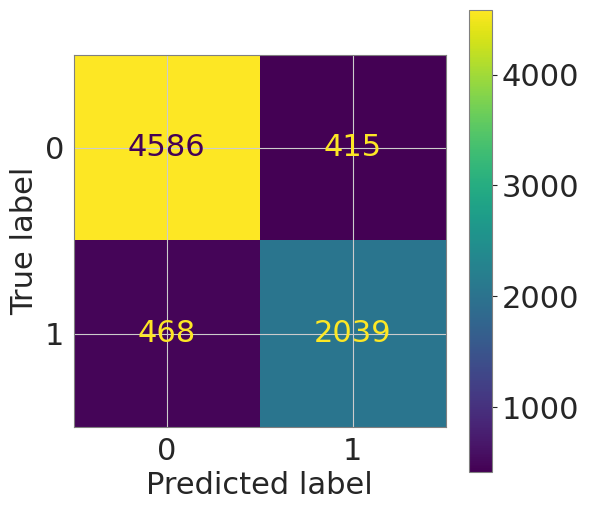

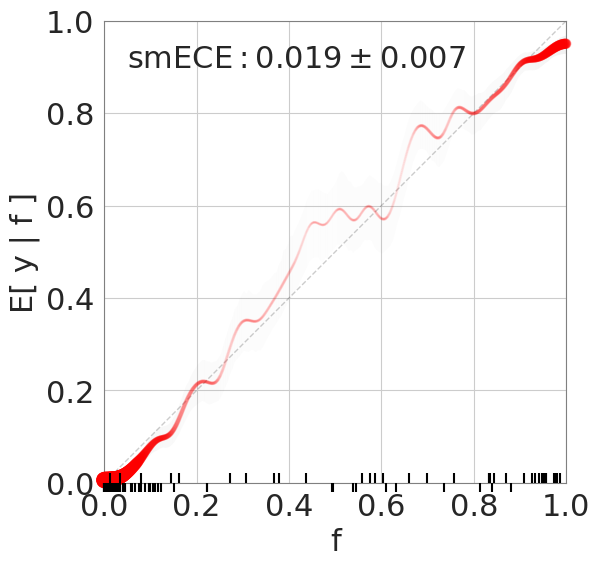

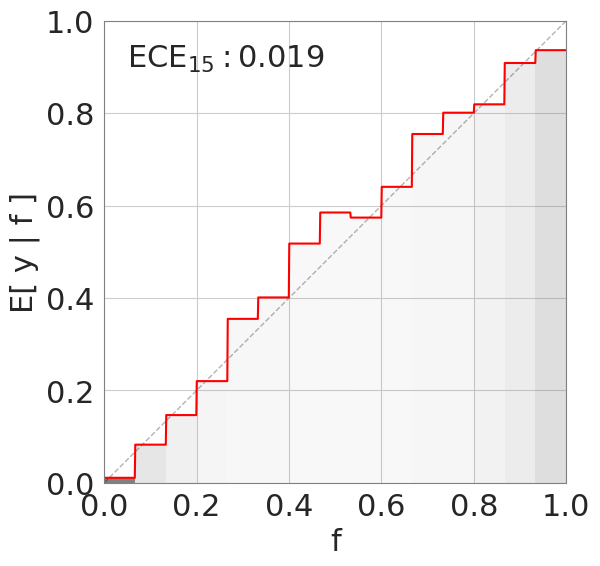

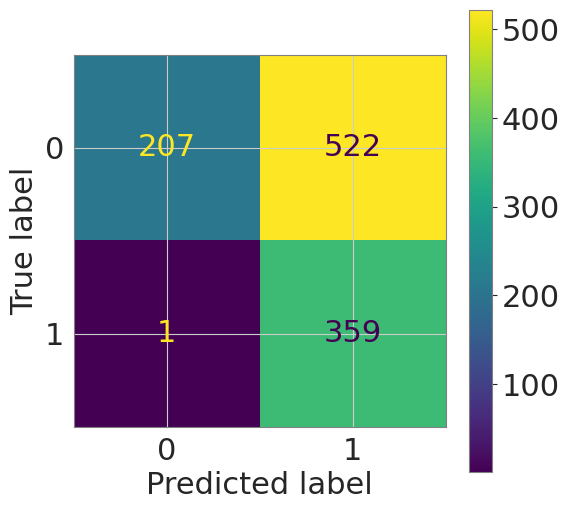

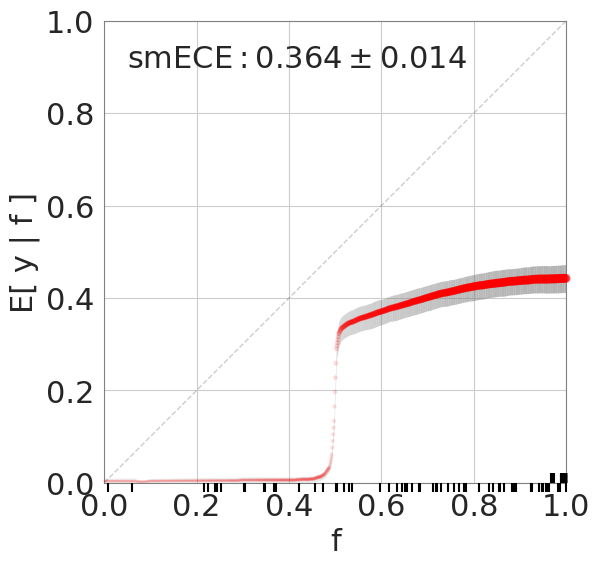

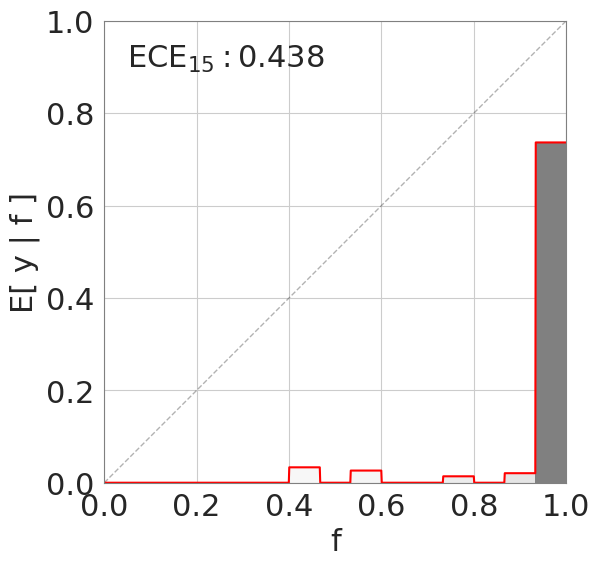

Computing plots and metrics for openai--ViT-B-32-quickgelu--0--airfield--isotonic


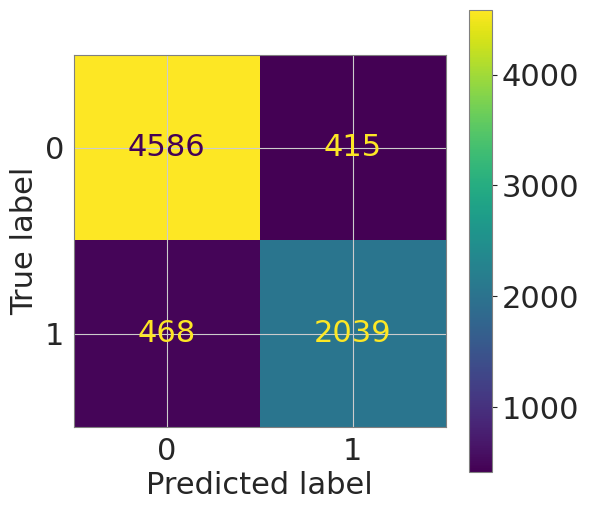

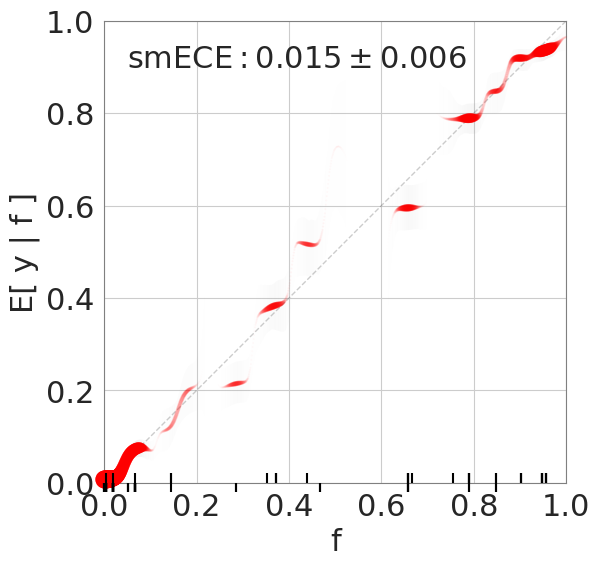

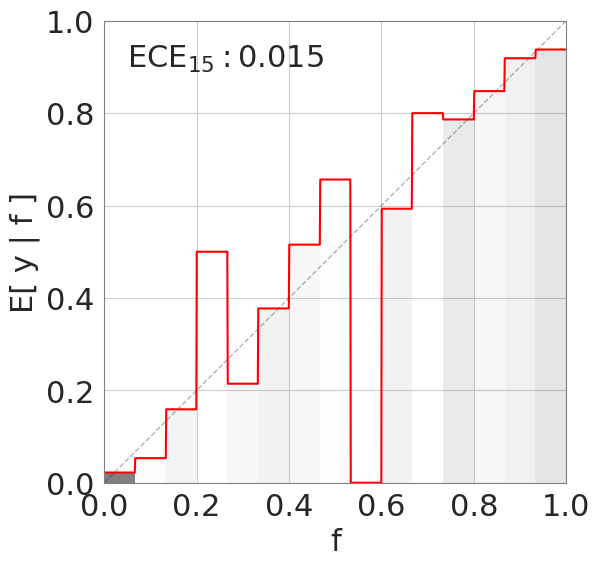

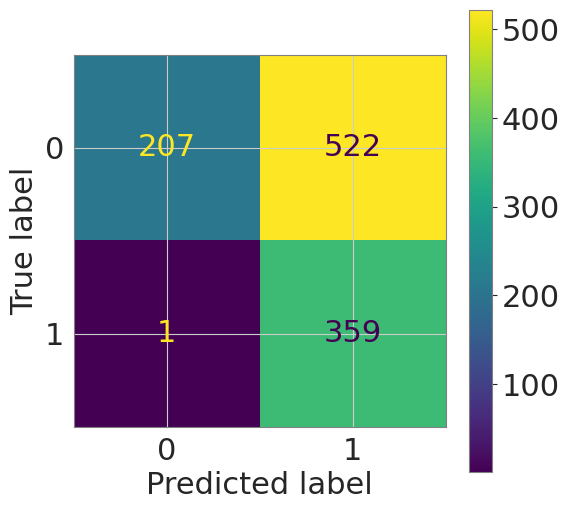

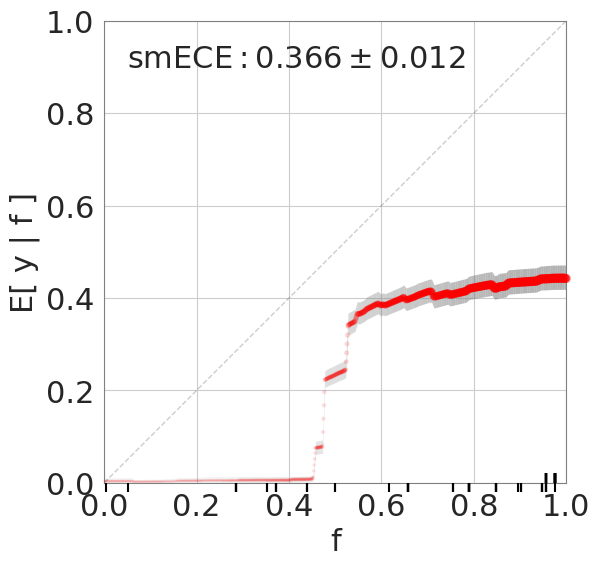

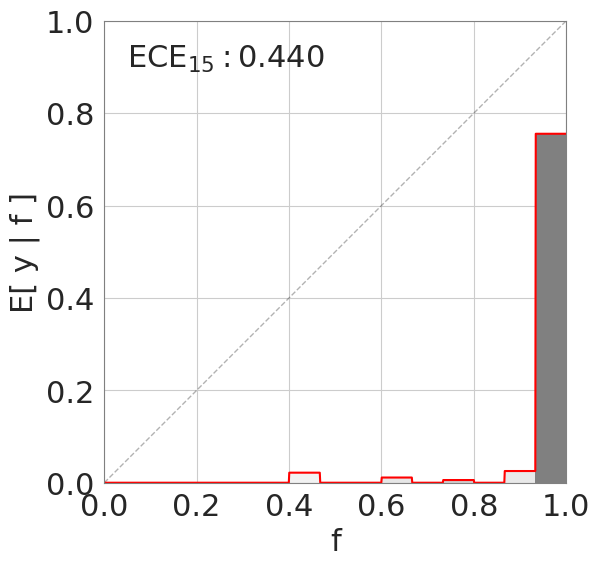

Computing plots and metrics for openai--ViT-B-32-quickgelu--0--airfield--sba


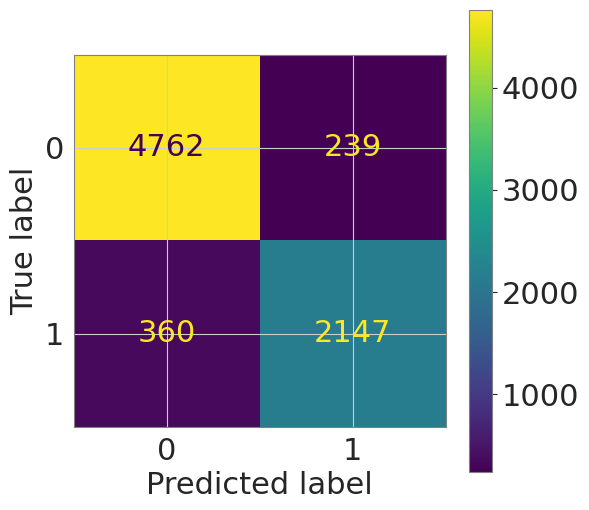

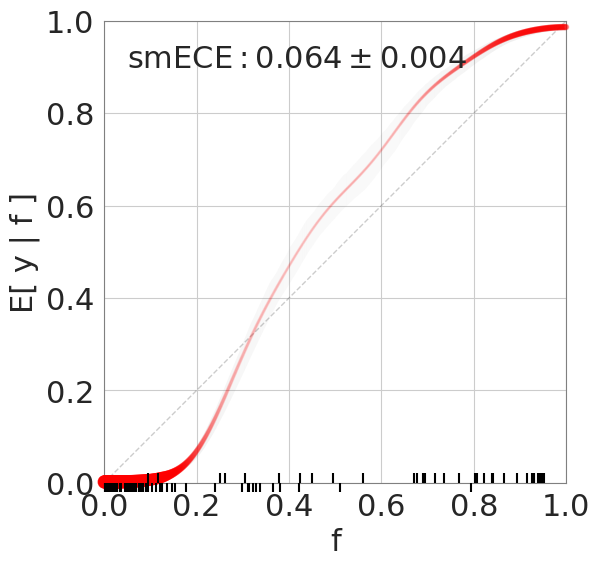

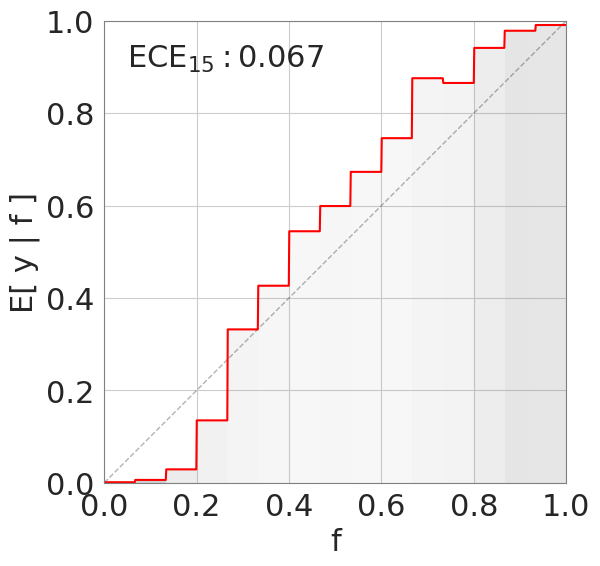

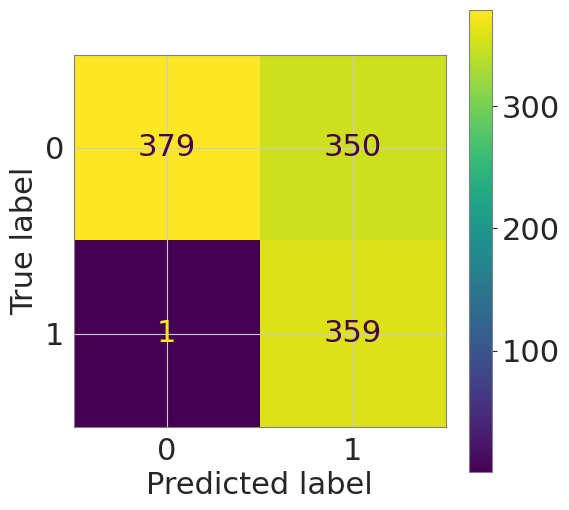

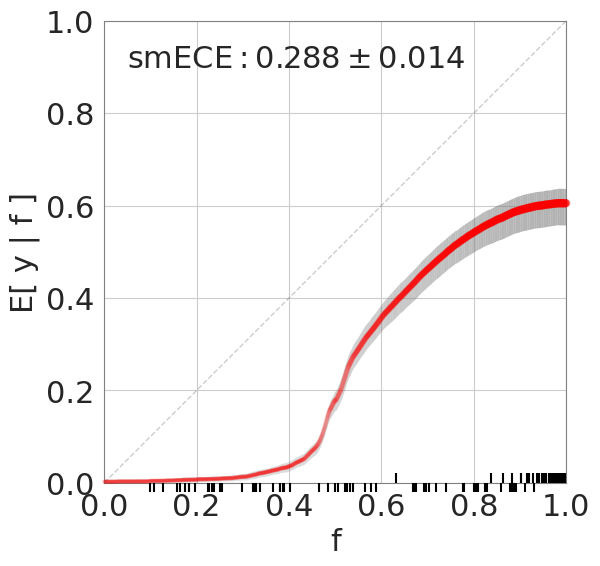

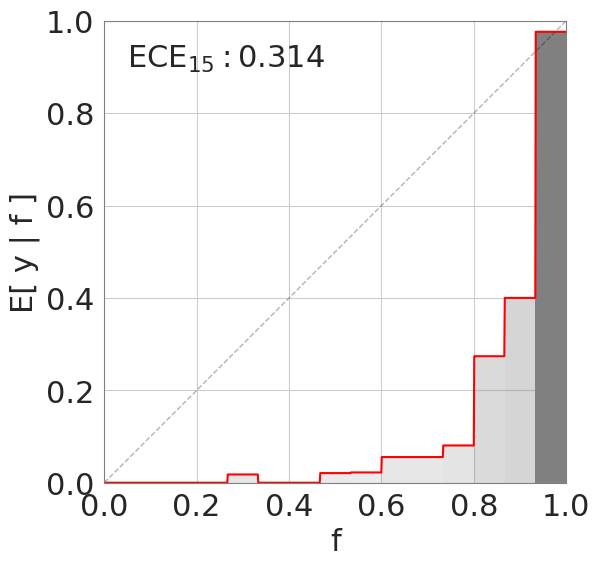

In [22]:
results_dir = pathlib.Path("/content/results")
all_results = []
for target_class_name in places_dataset.features["label"].names:
    target_class_id = places_dataset.features["label"].str2int(target_class_name)
    target_class_name_clean = places365_clean_label(target_class_name)
    print(f"Processing {target_class_name_clean} (class {target_class_id}) from Places365")
    zsc.set_text(target_class_name_clean)

    # make one-vs-rest version of dataset
    # note, we filter out some non-targets to make the dataset more balanced
    calibration_dataset = create_binary_dataset(places_dataset, target_class_id)
    calibration_dataset = build_scores_dataset(zsc, calibration_dataset)
    calibration_dataset = calibration_dataset.train_test_split(test_size=0.5, seed=42)

    # use AID as the out-of-domain test set
    ood_calibration_dataset = create_binary_dataset(aid_dataset, target_class_id)
    ood_calibration_dataset = build_scores_dataset(zsc, ood_calibration_dataset)

    for calibration_method in ["sigmoid", "isotonic", "sba"]:
        calibrator_args = [
            calibration_dataset["train"]["score"],
            calibration_dataset["train"]["label"],
        ]
        predict_proba_args = [calibration_dataset["test"]["score"]]
        ood_predict_proba_args = [ood_calibration_dataset["score"]]

        if calibration_method == "sigmoid":
            calibrator = SigmoidCalibrator()
        elif calibration_method == "isotonic":
            calibrator = IsotonicCalibrator()
        elif calibration_method == "sba":
            calibrator = SimilarityBinningAveragingCalibrator()
            calibrator_args.append(calibration_dataset["train"]["features"])
            predict_proba_args.append(calibration_dataset["test"]["features"])
            ood_predict_proba_args.append(ood_calibration_dataset["features"])
        else:
            raise ValueError(f"Unknown calibration method {calibration_method}")

        calibrator.fit(*calibrator_args)
        labels = calibration_dataset["test"]["label"]
        probs = calibrator.predict_proba(*predict_proba_args)
        preds = probs >= 0.5
        ood_labels = ood_calibration_dataset["label"]
        ood_probs = calibrator.predict_proba(*ood_predict_proba_args)
        ood_preds = ood_probs >= 0.5

        slug = f"{provider}--{model_name}--{target_class_id}--{target_class_name}--{calibration_method}"
        print(f"Computing plots and metrics for {slug}")
        results = {
            # classifier/calibrator metadata
            "model_name": model_name,
            "provider": provider,
            "target_class_id": target_class_id,
            "target_class_name": target_class_name,
            "target_class_name_clean": target_class_name_clean,
            "slug": slug,
            # in-domain classifier metrics
            "accuracy": sklearn.metrics.accuracy_score(labels, preds),
            "precision": sklearn.metrics.precision_score(labels, preds),
            "recall": sklearn.metrics.recall_score(labels, preds),
            "f1": sklearn.metrics.f1_score(labels, preds),
            # in-domain calibration metrics
            "brier_score": sklearn.metrics.brier_score_loss(labels, probs),
            "sm_ece": relplot.smECE(probs, labels),
            "binned_ece": relplot.metrics.binnedECE(probs, labels, nbins=15),
            # out-of-domain classifier metrics
            "ood_accuracy": sklearn.metrics.accuracy_score(ood_labels, ood_preds),
            "ood_precision": sklearn.metrics.precision_score(ood_labels, ood_preds),
            "ood_recall": sklearn.metrics.recall_score(ood_labels, ood_preds),
            "ood_f1": sklearn.metrics.f1_score(ood_labels, ood_preds),
            # out-of-domain calibration metrics
            "ood_brier_score": sklearn.metrics.brier_score_loss(ood_labels, ood_probs),
            "ood_sm_ece": relplot.smECE(ood_probs, ood_labels),
            "ood_binned_ece": relplot.metrics.binnedECE(ood_probs, ood_labels, nbins=15),
        }
        all_results.append(results)

        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(labels, preds)
        plt.savefig(f"/content/results/{slug}-confusion_matrix.png")
        plt.show()
        relplot.rel_diagram(probs, labels)
        plt.savefig(f"/content/results/{slug}-reliability_diagram.png")
        plt.show()
        relplot.rel_diagram_binned(probs, labels)
        plt.savefig(f"/content/results/{slug}-reliability_diagram_binned.png")
        plt.show()

        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(ood_labels, ood_preds)
        plt.savefig(f"/content/results/{slug}-ood-confusion_matrix.png")
        plt.show()
        relplot.rel_diagram(ood_probs, ood_labels)
        plt.savefig(f"/content/results/{slug}-ood-reliability_diagram.png")
        plt.show()
        relplot.rel_diagram_binned(ood_probs, ood_labels)
        plt.savefig(f"/content/results/{slug}-ood-reliability_diagram_binned.png")
        plt.show()
    break

## Analyze Results

In [23]:
results_df = pd.DataFrame(all_results)
results_df.to_csv("/content/results/metrics.csv")
results_df

,model_name,provider,target_class_id,target_class_name,target_class_name_clean,slug,accuracy,precision,recall,f1,brier_score,sm_ece,binned_ece,ood_accuracy,ood_precision,ood_recall,ood_f1,ood_brier_score,ood_sm_ece,ood_binned_ece
0,ViT-B-32-quickgelu,openai,0,airfield,airfield,openai--ViT-B-32-quickgelu--0--airfield--sigmoid,0.882392,0.830888,0.813323,0.822012,0.084707,0.019475,0.018747,0.519743,0.407491,0.997222,0.578566,0.339778,0.363985,0.438168
1,ViT-B-32-quickgelu,openai,0,airfield,airfield,openai--ViT-B-32-quickgelu--0--airfield--isotonic,0.882392,0.830888,0.813323,0.822012,0.084860,0.015019,0.015065,0.519743,0.407491,0.997222,0.578566,0.349627,0.366364,0.439824
2,ViT-B-32-quickgelu,openai,0,airfield,airfield,openai--ViT-B-32-quickgelu--0--airfield--sba,0.920218,0.899832,0.856402,0.877580,0.059130,0.063673,0.066567,0.677686,0.506347,0.997222,0.671656,0.211993,0.287816,0.314252
